In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data/Store_CA.csv')

target = 'MonthlySalesRevenue'
attributes = [col for col in df.columns if col != target]
numerical_attributes = df[attributes].select_dtypes(include=[np.number]).columns.tolist()

The Target variable is the MonthlySalesRevenue, and the attributes are the other columns in the dataset (See plot below).

# Data Analysis

## Attributes distributions

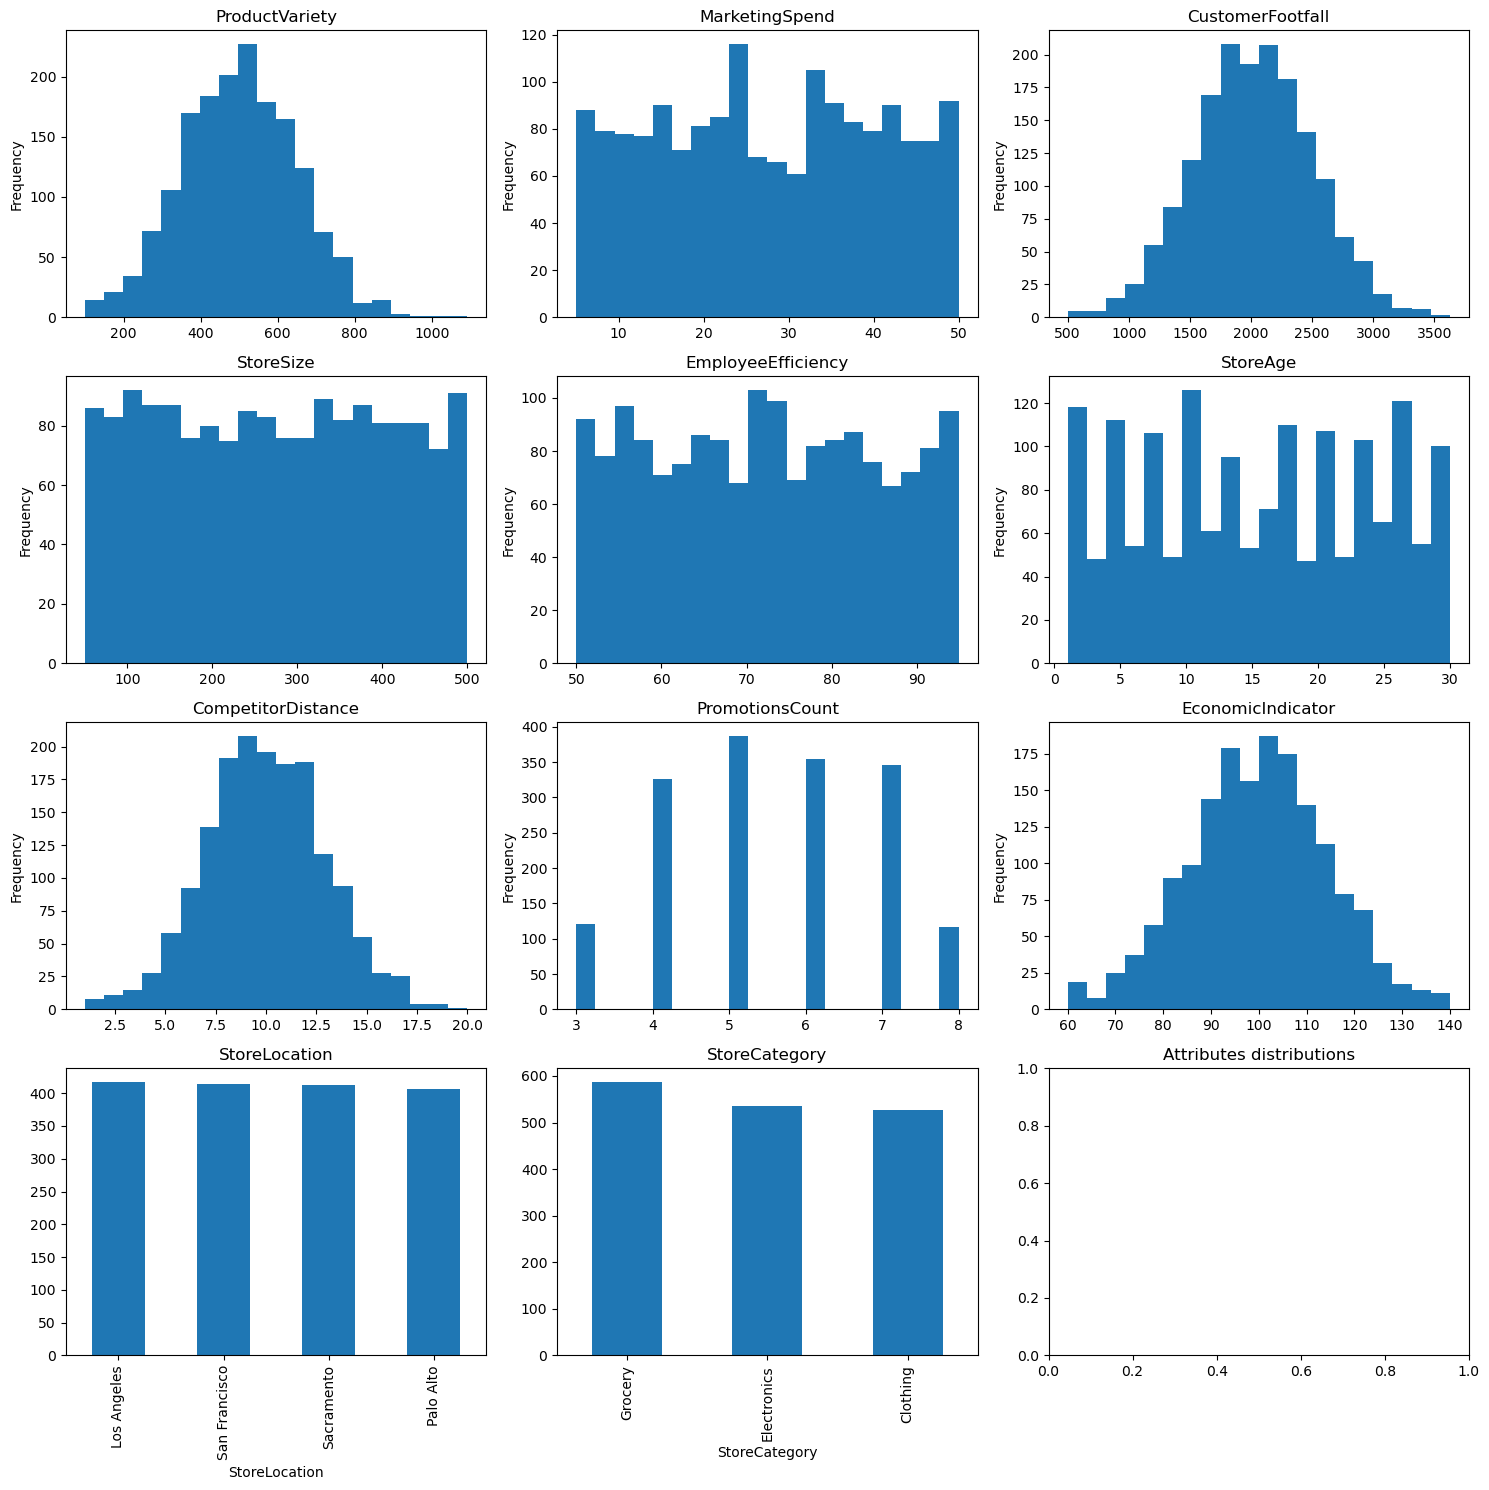

In [3]:

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.ravel()

for i, col in enumerate(attributes):
    if df[col].dtype == object:
        df[col].value_counts().plot(kind='bar', ax=axes[i], title=col)
    else:
        df[col].plot(kind='hist', ax=axes[i], title=col, bins=20)
plt.tight_layout()
plt.title('Attributes distributions')
plt.show()

### Description of Distributions

1. **Product Variety, Customer Footfall, Competitor Distance, and Economic Indicator**:
   These variables exhibit a roughly **normal distribution**, where values are concentrated around a central point with a symmetric spread. This type of distribution is common in natural and business contexts. For instance:
   - **Product Variety**: It is reasonable that stores with average product variety perform better, while extremely high or low variety might be less common.
   - **Customer Footfall**: Reflects typical customer traffic, where most stores experience moderate levels, and fewer stores have very high or low footfall.
   - **Competitor Distance**: Suggests that competitors are generally positioned within a similar range from each store.
   - **Economic Indicator**: Indicates that most stores operate in average economic conditions, with fewer in very high or low economic contexts.

2. **Marketing Spend, Employee Efficiency, and Store Age**:
   These variables display a **uniform-like distribution**, where values are spread evenly across the range:
   - **Marketing Spend**: Suggests variability in marketing investments, possibly influenced by store strategies or local market needs.
   - **Employee Efficiency**: Uniform distribution might arise from standardizing training or workforce policies across stores.
   - **Store Age**: Represents stores evenly distributed by their operational years, which might reflect a steady expansion strategy.

3. **Store Size**:
   This variable has a slightly skewed distribution with a peak around mid-sized stores, which is common as mid-sized stores often balance cost-effectiveness and capacity better than very small or very large stores.

4. **Promotions Count**:
   The distribution is **discrete** and approximately uniform, with most stores running between 3 to 8 promotions. This reflects structured marketing practices where stores aim to maintain similar promotional activity levels.

5. **Store Location and Store Category**:
   Both are **categorical variables** with bar distributions:
   - **Store Location**: Appears evenly distributed across locations like Los Angeles, San Francisco, Sacramento, and Palo Alto, indicating balanced regional operations.
   - **Store Category**: Shows a balance between Grocery, Electronics, and Clothing categories, likely reflecting equal investment or customer demand in these sectors.

The observed distributions align with practical business scenarios, such as optimizing store size and customer offerings, maintaining consistent marketing efforts, and ensuring efficient operations across locations and categories.


## Correlation

In [4]:
# Compute and print the correlation matrix of the attributes
correlation_matrix = df[numerical_attributes + [target]].corr()
print(correlation_matrix[[target]])

                     MonthlySalesRevenue
ProductVariety                  0.674146
MarketingSpend                 -0.006068
CustomerFootfall               -0.031482
StoreSize                       0.602992
EmployeeEfficiency              0.025451
StoreAge                        0.039384
CompetitorDistance             -0.022428
PromotionsCount                -0.002674
EconomicIndicator               0.037969
MonthlySalesRevenue             1.000000


### Correlation Analysis with Monthly Sales Revenue

The table below shows the correlation coefficients between various attributes and **Monthly Sales Revenue**. Positive values indicate a direct relationship, while negative values indicate an inverse relationship.

1. **Strong Positive Correlations**:
   - **Product Variety (0.674)**: A strong positive correlation suggests that increasing product variety is associated with higher monthly sales revenue. This makes sense, as a wider variety of products can attract more customers and meet diverse needs.
   - **Store Size (0.603)**: Larger stores tend to generate more revenue, likely due to their ability to stock more products and serve more customers.

2. **Weak Positive Correlations**:
   - **Employee Efficiency (0.025)**: There is a very weak positive correlation, indicating that employee efficiency has minimal impact on monthly sales revenue. This might suggest that other factors, such as store operations or product offerings, are more influential.
   - **Store Age (0.039)**: Older stores have a slightly positive relationship with sales revenue, possibly reflecting established customer bases or experience in operations.
   - **Economic Indicator (0.038)**: The slight positive correlation indicates that stores in better economic conditions tend to have slightly higher revenues.

3. **Weak Negative Correlations**:
   - **Customer Footfall (-0.031)**: Surprisingly, a weak negative correlation indicates that higher footfall does not necessarily translate to higher sales revenue. This might be due to low conversion rates or customer behavior in certain stores.
   - **Competitor Distance (-0.022)**: A very weak negative correlation suggests that competitor proximity has minimal impact on sales revenue, possibly due to strong differentiation strategies or brand loyalty.
   - **Marketing Spend (-0.006)**: The near-zero correlation implies that marketing spend has no significant direct relationship with monthly sales revenue. This could indicate inefficiencies in marketing strategies or varying effectiveness by store.
   - **Promotions Count (-0.003)**: The almost non-existent negative correlation indicates that the number of promotions has little to no impact on sales revenue. This could mean promotions are not well-targeted or have diminishing returns.


### Insights:
- **Key Drivers of Sales**: Product variety and store size are the most significant drivers of monthly sales revenue.
- **Limited Impact Variables**: Attributes like marketing spend, promotions count, and competitor distance have negligible correlations, indicating that they may not directly influence sales revenue or their effects are masked by other factors.


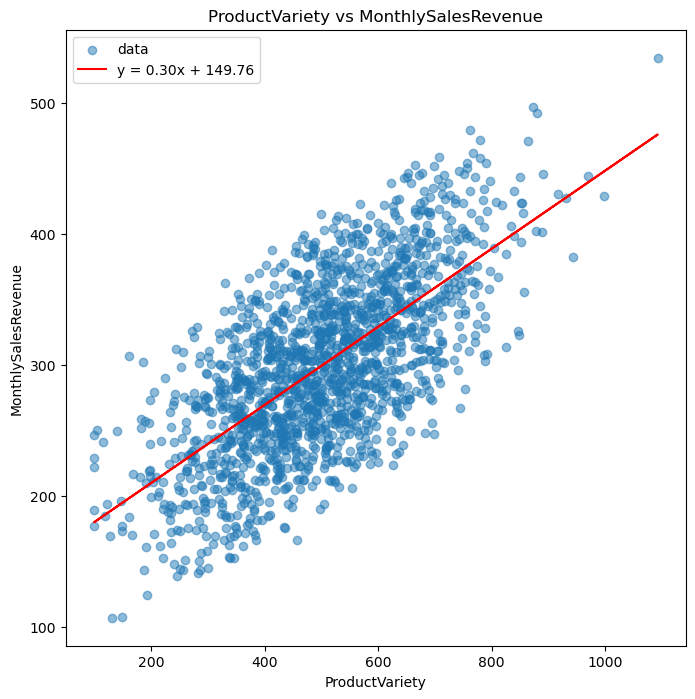

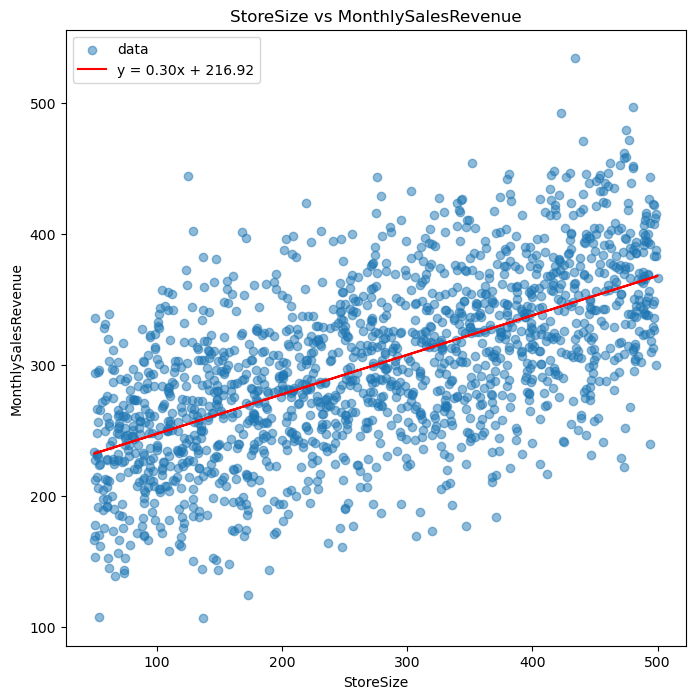

In [5]:
# plot the target value against ProductVariety and StoreSize with the lsq line
plt.figure(figsize=(8, 8))
plt.scatter(df['ProductVariety'], df[target], alpha=0.5)
# Fit a linear regression model
x = df['ProductVariety']
y = df[target]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')
plt.xlabel('ProductVariety')
plt.ylabel(target)
plt.title('ProductVariety vs MonthlySalesRevenue')
plt.legend(['data', 'y = {:.2f}x + {:.2f}'.format(m, b)])
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(df['StoreSize'], df[target], alpha=0.5)
# Fit a linear regression model
x = df['StoreSize']
y = df[target]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')
plt.xlabel('StoreSize')
plt.ylabel(target)
plt.title('StoreSize vs MonthlySalesRevenue')
plt.legend(['data', 'y = {:.2f}x + {:.2f}'.format(m, b)])
plt.show()


Those plots show the relationship between the target value and the two most correlated attributes with the target value. The red line represents the least square line that fits the data points. The first plot shows a positive relationship between the target value and the ProductVariety attribute. The second plot shows a positive relationship between the target value and the StoreSize attribute.

## Section 3: Data Preprocessing

In [17]:


# Load the dataset
df = pd.read_csv('data/Store_CA.csv')

# Define the target and features
target = 'MonthlySalesRevenue'
features = [col for col in df.columns if col != target]

# Convert object types to categorical
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Initialize the XGBoost regressor with enable_categorical parameter
model = XGBRegressor(enable_categorical=True)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1126.7924130469676


## Error Analysis

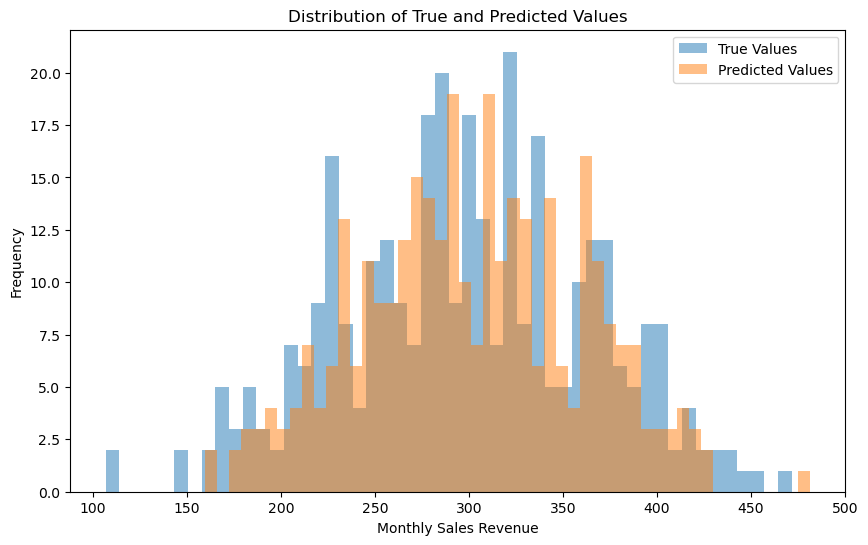

In [28]:
# Plot the distribution of the predicted values and the truth labels
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=50, alpha=0.5, label='True Values')
plt.hist(y_pred, bins=50, alpha=0.5, label='Predicted Values')
plt.xlabel('Monthly Sales Revenue')
plt.ylabel('Frequency')
plt.title('Distribution of True and Predicted Values')
plt.legend()
plt.show()

We can see that the distribution of the predicted values is similar to the distribution of the true values, indicating that the model is capturing the underlying patterns in the data.

In [23]:
# Calculate residuals
residuals = y_test - y_pred

# Add residuals to the DataFrame for analysis
results_df = X_test.copy()
results_df['True Values'] = y_test
results_df['Predicted Values'] = y_pred
results_df['Residuals'] = residuals
# Identify the worst predictions (highest absolute residuals)
worst_predictions = results_df.nlargest(30, 'Residuals')

# Identify the best predictions (lowest absolute residuals)
best_predictions = results_df.nsmallest(30, 'Residuals')


In [24]:

print("Worst Predictions:")
worst_predictions


Worst Predictions:


,ProductVariety,MarketingSpend,CustomerFootfall,StoreSize,EmployeeEfficiency,StoreAge,CompetitorDistance,PromotionsCount,EconomicIndicator,StoreLocation,StoreCategory,True Values,Predicted Values,Residuals
109,331,9,2302,488,73.0,16,9,3,89.9,Sacramento,Grocery,362.36,290.177368,72.182632
1284,534,43,2587,317,93.4,15,9,8,102.7,Palo Alto,Grocery,374.23,302.667664,71.562336
1361,571,23,2396,186,61.0,12,12,5,92.8,Palo Alto,Clothing,323.80,254.251526,69.548474
471,285,26,1994,329,87.6,11,10,5,107.6,Palo Alto,Electronics,301.09,232.351120,68.738880
926,533,40,1223,124,74.4,1,11,7,89.7,Sacramento,Clothing,301.18,236.200333,64.979667
297,665,46,2204,470,54.9,1,11,7,110.2,Los Angeles,Electronics,452.44,387.785614,64.654386
1090,361,5,2454,359,87.7,25,11,3,114.2,Sacramento,Clothing,336.53,273.697113,62.832887
710,544,23,2372,314,55.1,10,9,5,115.6,Los Angeles,Electronics,365.33,303.578796,61.751204
601,525,37,1834,114,69.7,5,14,7,94.5,Los Angeles,Electronics,294.35,232.692490,61.657510
432,234,24,1624,310,81.1,1,9,5,96.6,Palo Alto,Grocery,263.87,204.334183,59.535817


In [26]:

print("Best Predictions:")
best_predictions

Best Predictions:


,ProductVariety,MarketingSpend,CustomerFootfall,StoreSize,EmployeeEfficiency,StoreAge,CompetitorDistance,PromotionsCount,EconomicIndicator,StoreLocation,StoreCategory,True Values,Predicted Values,Residuals
1035,324,12,1450,205,93.4,10,14,4,78.3,Sacramento,Grocery,186.26,273.284210,-87.024210
414,825,49,2567,132,55.8,11,10,8,93.6,Sacramento,Electronics,313.33,389.118927,-75.788927
1393,439,24,1613,382,82.7,17,9,5,108.6,San Francisco,Clothing,267.40,342.494354,-75.094354
843,132,35,2766,137,79.5,16,9,7,92.9,Palo Alto,Clothing,106.71,180.407440,-73.697440
494,554,6,1978,53,80.8,18,16,4,98.4,Los Angeles,Grocery,205.50,273.112854,-67.612854
413,150,31,2034,54,53.2,24,11,5,106.3,Los Angeles,Electronics,107.16,173.761353,-66.601353
168,713,16,1983,344,67.9,19,1,4,104.6,Palo Alto,Grocery,336.78,400.585938,-63.805938
1145,624,36,1412,461,53.5,12,12,7,87.5,Sacramento,Grocery,357.00,419.611664,-62.611664
964,433,5,1841,349,53.5,6,8,4,108.0,Palo Alto,Grocery,248.04,309.970490,-61.930490
1178,187,26,1642,190,86.6,25,8,6,94.0,Los Angeles,Clothing,143.47,204.907791,-61.437791


In [27]:
# Count overestimations and underestimations
overestimations = results_df[results_df['Residuals'] < 0].shape[0]
underestimations = results_df[results_df['Residuals'] > 0].shape[0]

print(f"Overestimations: {overestimations}")
print(f"Underestimations: {underestimations}")

Overestimations: 182
Underestimations: 148


In [13]:
# Calculate feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
               Feature  Importance
3            StoreSize    0.443977
0       ProductVariety    0.326383
4   EmployeeEfficiency    0.038550
10       StoreCategory    0.028510
5             StoreAge    0.027081
7      PromotionsCount    0.026033
8    EconomicIndicator    0.023849
6   CompetitorDistance    0.022671
2     CustomerFootfall    0.021562
9        StoreLocation    0.021175
1       MarketingSpend    0.020211


From thoses results, we can see that the model is making more underestimations than overestimations. The feature importances show that the ProductVariety attribute is the most important feature for predicting the MonthlySalesRevenue, followed by the StoreSize attribute. Which is coherent with the correlation analysis.

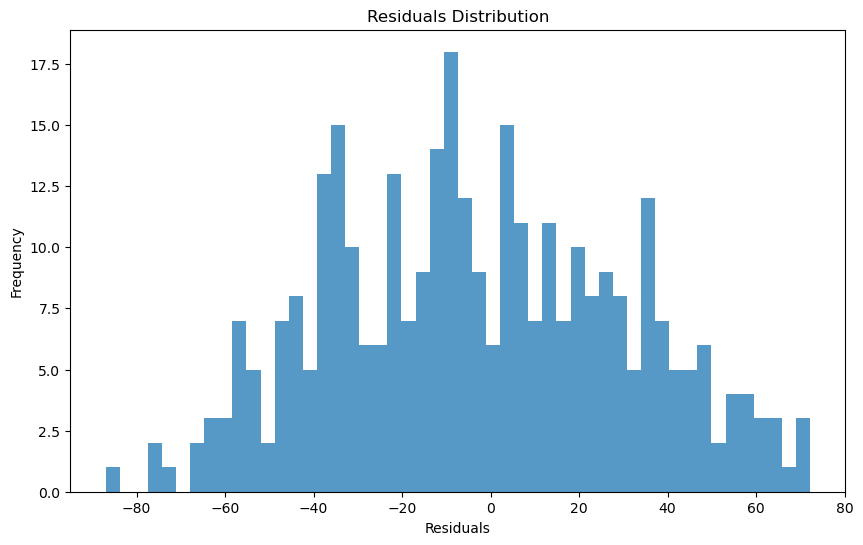

In [15]:
import matplotlib.pyplot as plt

# Plot residuals distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

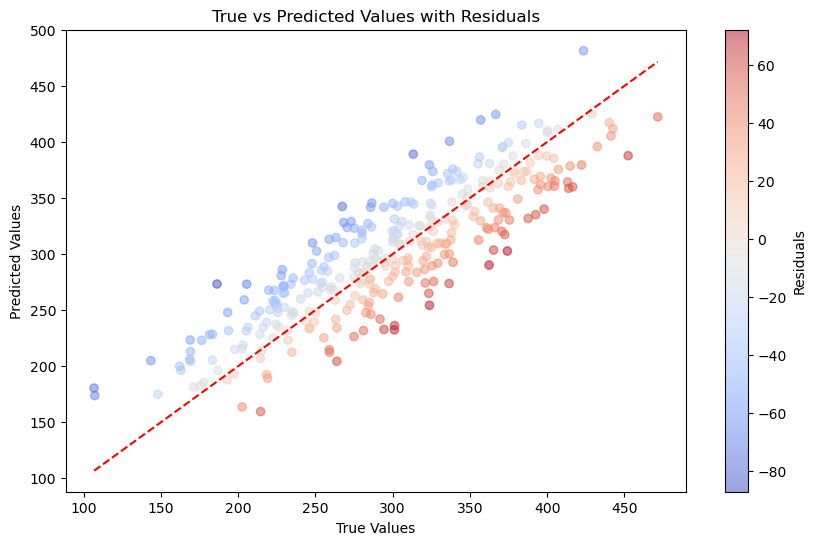

In [16]:
# Plot true vs predicted values with residuals
plt.figure(figsize=(10, 6))
plt.scatter(results_df['True Values'], results_df['Predicted Values'], alpha=0.5, c=residuals, cmap='coolwarm')
plt.colorbar(label='Residuals')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values with Residuals')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line y=x for reference
plt.show()

As we can see from the plot, the model's predictions are close to the true values for most data points, as the residuals are centered around zero. The color gradient represents the residuals, with blue indicating underestimations and red indicating overestimations.